In [1]:
import os
import sys

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()
sns.set()
# plt.style.use('fivethirtyeight')
import scienceplots
plt.style.context(['science', 'nature', 'muted'])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import dalex as dx

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import (make_scorer, confusion_matrix, 
                             accuracy_score, brier_score_loss,
                             precision_score, recall_score,
                             f1_score, cohen_kappa_score,
                             average_precision_score,
                             precision_recall_curve)
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)
ALGORITHM_NAME = "xgb"

COUNTRY2 = 'full_merged_dumvar'
TRAIN_PATH2, TEST_PATH2 = get_data_filepaths(COUNTRY2)

COUNTRY = 'full_merged'
TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

In [2]:
#XGBoost
# Load and transform the training data
X_train_xgb, y_train_xgb, w_train_xgb = split_features_labels_weights(TRAIN_PATH)
# X_train_xgb = X_train_xgb.to_numpy()
# w_train_xgb = w_train_xgb.to_numpy().reshape(-1)
# y_train_xgb = y_train_xgb.to_numpy().reshape(-1)
# Load the test set
X_test_xgb, y_test_xgb, w_test_xgb = split_features_labels_weights(TEST_PATH)
# X_test_xgb = X_test_xgb.to_numpy()
# w_test_xgb = w_test_xgb.to_numpy().reshape(-1)
# y_test_xgb = y_test_xgb.to_numpy().reshape(-1)


CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 84 ms
CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 10.7 ms
In-sample score: 86.52%


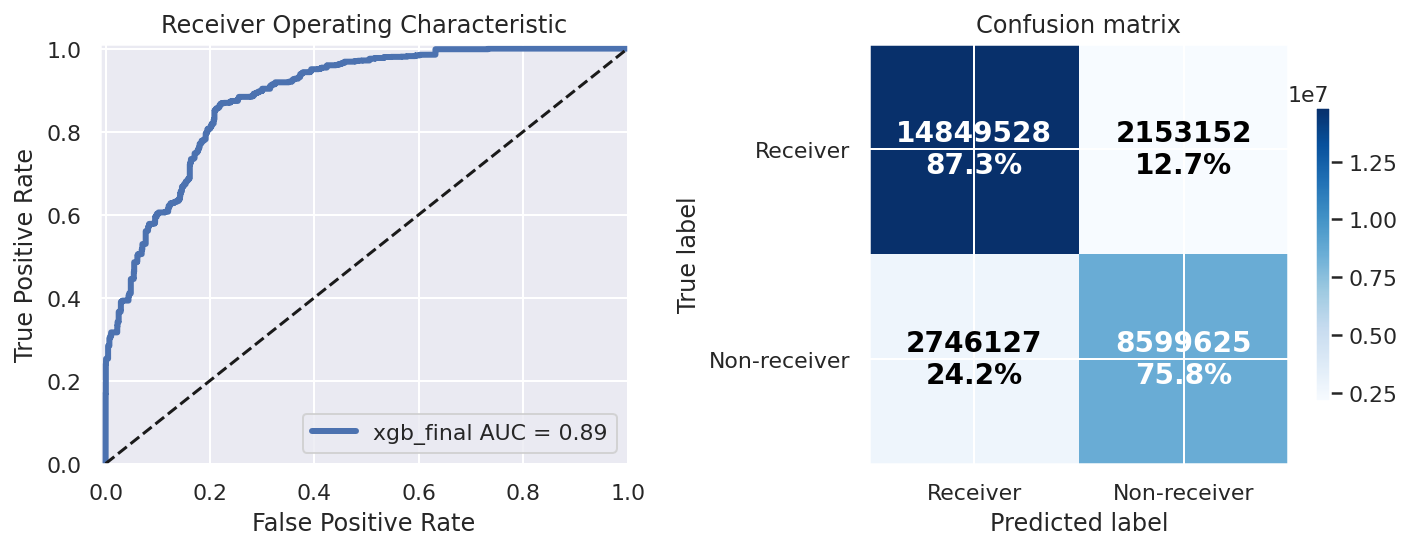

,xgb_final
accuracy,0.827176
recall,0.873364
precision,0.843932
f1,0.858396
cross_entropy,0.430164
roc_auc,0.885883
cohen_kappa,0.502402


In [3]:
model = XGBClassifier(tree_method="hist", 
                                                objective='binary:logistic',
                                                base_score=None,
                                                booster='gbtree', callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=True,
                                                eval_metric='logloss',
                                                feature_types=None, gamma=100,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=0.2, max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=1,
                                                max_delta_step=5, max_depth=None,
                                                max_leaves=None,
                                                min_child_weight=None,
                                                monotone_constraints=None,
                                                n_estimators=25, n_jobs=None,
                                                num_parallel_tree=None,
                                                predictor=None,
                                                random_state=None)
%time model.fit(X_train_xgb, y_train_xgb, sample_weight=w_train_xgb)

# Get an initial score
%time score = model.score(X_train_xgb, y_train_xgb)
print("In-sample score: {:0.2%}".format(score))
# feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)


# Run the model
y_pred = model.predict(X_test_xgb)
y_prob = model.predict_proba(X_test_xgb)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test_xgb, y_pred, y_prob, w_test_xgb.to_numpy().reshape(-1), 
                                    store_model=False,
                                    model_name='final', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
#                                     features=feat_imps,
                                    predict_dig_wage_rate=False)

In [65]:
X_test_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 118568 to 104173
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   economy              1452 non-null   category
 1   female               1452 non-null   category
 2   age                  1452 non-null   category
 3   educ                 1452 non-null   category
 4   inc_q                1452 non-null   category
 5   emp_in               1452 non-null   category
 6   urbanicity_f2f       1452 non-null   category
 7   account              1452 non-null   category
 8   fin14_1              1452 non-null   category
 9   fin16                1452 non-null   category
 10  fin17a               1452 non-null   category
 11  fin17b               1452 non-null   category
 12  fin22a               1452 non-null   category
 13  fin22b               1452 non-null   category
 14  fin24                1452 non-null   category
 15  fin33         

In [80]:
titanic_rf_exp = dx.Explainer(model, X_test_xgb, y_test_xgb, 
                    label = "XGBoost")

Preparation of a new explainer is initiated

  -> data              : 1452 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 1452 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost
  -> predict function  : <function yhat_proba_default at 0x7fe1399d41f0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00356, mean = 0.627, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.988, mean = 0.00809, max = 0.993
  -> model_info        : package xgboost

A new explainer has been created!


In [81]:
varsd =['economy', 'female', 'age', 'educ', 'inc_q', 'emp_in',
                                         'urbanicity_f2f', 'account', 'fin14_1', 'fin16', 'fin17a', 'fin17b',
                                         'fin22a', 'fin22b', 'fin24', 'fin33', 'pay_utilities', 'remittances',
                                         'mobileowner','internetaccess', 'merchantpay_dig','internet_fin_transc']

In [108]:
al_rf1 = titanic_rf_exp.model_profile(type = 'accumulated', variables = varsd, N = 1452, random_state=1042)
al_rf1.result['_label_'] = 'AL profiles'
al_rf1.result.head(30)

Calculating ceteris paribus:   0%|          | 0/22 [00:00<?, ?it/s]/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attem

Calculating ceteris paribus: 100%|██████████| 22/22 [00:00<00:00, 43.10it/s]
/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:79: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

Calculating accumulated dependency: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]


,_vname_,_label_,_x_,_yhat_,_ids_
0,account,AL profiles,1,0.618017,0
1,account,AL profiles,0,0.222224,0
0,age,AL profiles,1,0.618017,0
1,age,AL profiles,2,0.610995,0
2,age,AL profiles,3,0.609101,0
3,age,AL profiles,4,0.641651,0
0,economy,AL profiles,22,0.618017,0
1,economy,AL profiles,8,0.792433,0
2,economy,AL profiles,5,0.647202,0
3,economy,AL profiles,19,0.616249,0


In [104]:
ld_rf1 = titanic_rf_exp.model_profile(type = 'conditional', variables = varsd, N = 1452, variable_type='categorical',
                                       random_state=1042)
ld_rf1.result['_label_'] = 'LD profiles'
ld_rf1.result.head(30)

Calculating ceteris paribus:   0%|          | 0/22 [00:00<?, ?it/s]/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attem

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

Calculating ceteris paribus: 100%|██████████| 22/22 [00:00<00:00, 37.46it/s]
/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:79: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

Calculating conditional dependency: 100%|██████████| 22/22 [00:00<00:00, 433.99it/s]


,_vname_,_label_,_x_,_yhat_,_ids_
0,account,LD profiles,1,0,0
1,account,LD profiles,0,0,0
0,age,LD profiles,1,0,0
1,age,LD profiles,2,0,0
2,age,LD profiles,3,0,0
3,age,LD profiles,4,0,0
0,economy,LD profiles,22,0,0
1,economy,LD profiles,8,0,0
2,economy,LD profiles,5,0,0
3,economy,LD profiles,19,0,0


In [105]:
ld_rf = titanic_rf_exp.model_profile(type = 'conditional', random_state=1042, N = 1452)
ld_rf.result['_label_'] = 'LD profiles'
ld_rf.result.head(30)

Calculating ceteris paribus:   0%|          | 0/22 [00:00<?, ?it/s]/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attem

Calculating ceteris paribus: 100%|██████████| 22/22 [00:00<00:00, 39.04it/s]
/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:79: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

Calculating conditional dependency: 100%|██████████| 22/22 [00:00<00:00, 295.25it/s]


,_vname_,_label_,_x_,_yhat_,_ids_
0,account,LD profiles,1,0.754592,0
1,account,LD profiles,0,0.113048,0
0,age,LD profiles,1,0.620306,0
1,age,LD profiles,2,0.643970,0
2,age,LD profiles,3,0.656269,0
3,age,LD profiles,4,0.684153,0
0,economy,LD profiles,22,0.561421,0
1,economy,LD profiles,8,0.731575,0
2,economy,LD profiles,5,0.573200,0
3,economy,LD profiles,19,0.594829,0


In [106]:
# ld_rf1.result._x_[3]
# ld_rf1.result.index = np.arange(1, len(ld_rf1.result) + 1)
# ld_rf1.result = ld_rf1.result.drop(7)
# ld_rf1.result = ld_rf1.result.drop(ld_rf1.result[(ld_rf1.result._vname_ == 'age') & (ld_rf1.result._x_ == '')].index)
# ld_rf1.result.dropna(inplace=True)
ld_rf1.result['_yhat_'] = ld_rf.result['_yhat_'].values
ld_rf1.result.head(30)

,_vname_,_label_,_x_,_yhat_,_ids_
0,account,LD profiles,1,0.754592,0
1,account,LD profiles,0,0.113048,0
0,age,LD profiles,1,0.620306,0
1,age,LD profiles,2,0.643970,0
2,age,LD profiles,3,0.656269,0
3,age,LD profiles,4,0.684153,0
0,economy,LD profiles,22,0.561421,0
1,economy,LD profiles,8,0.731575,0
2,economy,LD profiles,5,0.573200,0
3,economy,LD profiles,19,0.594829,0


In [59]:
ld_rf1.plot(al_rf1, variables = varsd)

In [148]:
ld_rf1.plot(al_rf1, variables = ['mobileowner'])

In [149]:
ld_rf1.plot(al_rf1, variables = ['fin14_1'])

In [132]:
pd_rf = titanic_rf_exp.model_profile(type = 'partial', variables = varsd, N = 1452, variable_type='categorical',
                                       random_state=1042)
pd_rf.result

Calculating ceteris paribus:   0%|          | 0/22 [00:00<?, ?it/s]/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:104: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attem

Calculating ceteris paribus: 100%|██████████| 22/22 [00:00<00:00, 52.59it/s]
/home/socrates/.local/lib/python3.9/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:79: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



,_vname_,_label_,_x_,_yhat_,_ids_
0,economy,XGBoost,22,0.555172,0
1,economy,XGBoost,8,0.733328,0
2,economy,XGBoost,5,0.598257,0
3,economy,XGBoost,19,0.567070,0
4,economy,XGBoost,13,0.740488,0
...,...,...,...,...,...
78,internetaccess,XGBoost,2,0.632702,0
79,merchantpay_dig,XGBoost,0,0.610311,0
80,merchantpay_dig,XGBoost,1,0.671475,0
81,internet_fin_transc,XGBoost,1,0.608132,0


In [151]:
pd_rf.plot(variables = ['fin14_1'])